<a href="https://colab.research.google.com/github/prog815/abscur_prediction/blob/master/%D0%9F%D1%80%D0%BE%D0%B3%D0%BD%D0%BE%D0%B7%D0%B8%D1%80%D1%83%D0%B5%D0%BC_(KNeighborsClassifier)_%D0%B7%D0%BD%D0%B0%D0%BA_%D0%BE%D1%82%D0%BD%D0%BE%D1%81%D0%B8%D1%82%D0%B5%D0%BB%D1%8C%D0%BD%D1%8B%D1%85_%D0%B8%D0%B7%D0%BC%D0%B5%D0%BD%D0%B5%D0%BD%D0%B8%D0%B9_%D0%B0%D0%B1%D1%81%D0%BE%D0%BB%D1%8E%D1%82%D0%BD%D1%8B%D1%85_%D0%B2%D0%B0%D0%BB%D1%8E%D1%82%D0%BD%D1%8B%D1%85_%D0%BA%D1%83%D1%80%D1%81%D0%BE%D0%B2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Прогнозируем (KNeighborsClassifier) знак относительных изменений абсолютных валютных курсов**

**Абсолютный курс**

Енин А.В.

г. Оренбург

2020 г.

Сайт - http://www.abscur.ru

Twitter - https://twitter.com/abscurs

ВКонтакте -  https://vk.com/abscur

Одноклассники -  https://ok.ru/group/53547043520717

FB -  https://www.facebook.com/abscur 

Telegram - https://t.me/AbsCur

GitHub - https://github.com/prog815/abscur_prediction

Прогнозируем направление относительных изменений абсолютного курса. Для этого применяем модель К ближайших соседей (KNeighborsClassifier) по предыдущим значениям (с некоторым окном) относительных изменений абсолютного курса.

# Библиотеки

In [39]:
import datetime
print(datetime.date.today())

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import *

2020-04-01


# Импорт данных

Таблица с историей абсолютных курсов: https://docs.google.com/spreadsheets/d/1_-cdNCIC6NgyRDj0zLJBaohXo-K8qCfxfDLbYq2JLhs/edit#gid=422799220

In [9]:
data_url = 'https://docs.google.com/spreadsheets/d/1_-cdNCIC6NgyRDj0zLJBaohXo-K8qCfxfDLbYq2JLhs/export?format=csv&id=1_-cdNCIC6NgyRDj0zLJBaohXo-K8qCfxfDLbYq2JLhs&gid=422799220'
abs_data = pd.read_csv(data_url,decimal=',',parse_dates=True,index_col=0)
abs_data.shape

(1306, 45)

# Подготовка данных

Вычисляем матрицу относительных изменений абсолютных валютных курсов

In [0]:
dates = abs_data.index.values # даты
cur_names = abs_data.columns.values # имена валют
data = abs_data.values # матрица абсолютных курсов
d_data = np.zeros_like(data) # матрица относительных изменений
d_data[1:,:] = (data[1:,:]-data[:-1,:])/data[:-1,:] # расчет матрицы относительных изменений

# Готовоим входы и выходы модели

Нормируем относительные изменения.
Сибираем матрицу входов и выходов для модели прогнозирования.

In [0]:
window = 30 # окно для входов

y = d_data.copy()

y = (y - y.mean(axis=0)) / y.std(axis=0) # нормируем

x_ = [0]*window

for w in range(window):
    x_[w] = np.zeros_like(y)
    x_[w][(1+w):,:] = y[:(-1-w),:]

X = np.concatenate(x_,axis=1)[window:,:]
y = y[window:]
y = np.array(y >= 0,dtype=float) # переводим в бинарный вид

In [19]:
X.shape,y.shape

((1276, 1350), (1276, 45))

# Учим модель

Используем стандартный пакет **scikit-learn**

https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier

Готовим обучающую и тестовую выборки. Не перемешиваем. Выборки последовательные.

Создаем модель.
Учим модель на обучающей выборке. В цикле для каждого выхода учим по одной модели.

Прогнозируем результаты для тестовой и обучающей выборок.


In [22]:
X_train,X_test,y_train,y_test = train_test_split(X,y,shuffle=False)

preds_train = np.zeros_like(y_train)
preds_test = np.zeros_like(y_test)

for k in range(y_train.shape[1]):
    cl = KNeighborsClassifier(n_neighbors=3)
    cl.fit(X_train,y_train[:,k])
    preds_train[:,k] = cl.predict(X_train)
    preds_test[:,k] = cl.predict(X_test)
    print(k,end=' ')

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 

# Метрики на одной валюте



In [38]:
n = np.random.randint(y.shape[1])

print('метрики для',cur_names[n].upper())

print('---- accuracy_score -----')
print('train', accuracy_score(y_train[:,n],preds_train[:,n]))
print('test',accuracy_score(y_test[:,n],preds_test[:,n]))

print('---- f1_score -----')
print('train', f1_score(y_train[:,n],preds_train[:,n]))
print('test',f1_score(y_test[:,n],preds_test[:,n]))

print('---- confusion_matrix -----')
print('train\n',confusion_matrix(y_train[:,n],preds_train[:,n]))
print('test\n',confusion_matrix(y_test[:,n],preds_test[:,n]))

метрики для BRL
---- accuracy_score -----
train 0.7711598746081505
test 0.5047021943573667
---- f1_score -----
train 0.7951356407857813
test 0.49032258064516127
---- confusion_matrix -----
train
 [[313 106]
 [113 425]]
test
 [[85 71]
 [87 76]]


сильно сжалось по оси Y 
предсказания на порядок ниже чем оргинал

# Метрики на всех

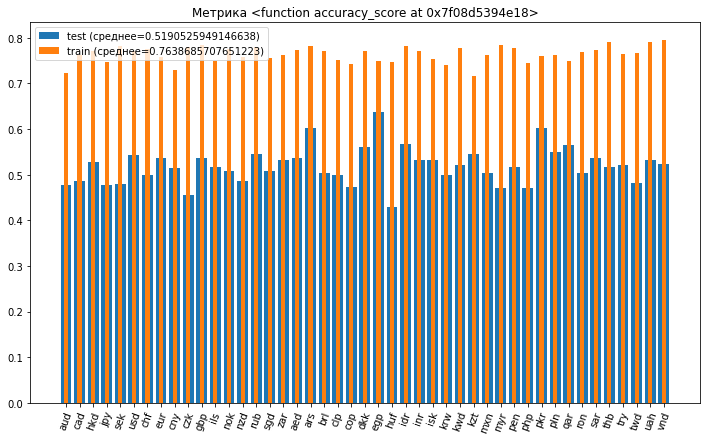

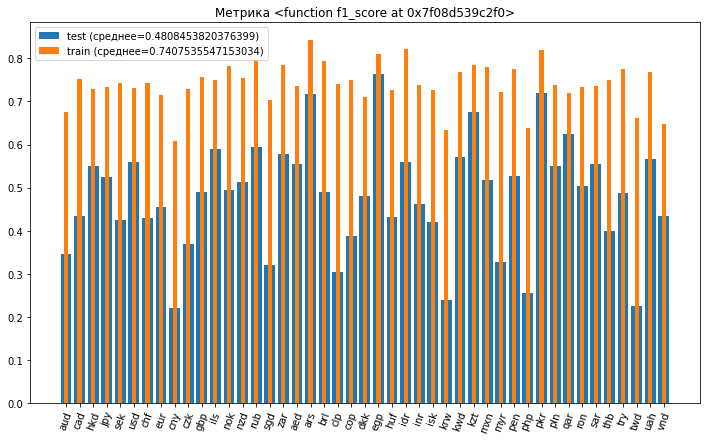

In [40]:
def my_metric(metric_func):
    train_ = [metric_func(y_train[:,k],preds_train[:,k]) for k in range(y.shape[1])]
    test_ = [metric_func(y_test[:,k],preds_test[:,k]) for k in range(y.shape[1])]

    plt.figure(figsize=(12,7))
    plt.bar(cur_names,test_,label="test (среднее={})".format(np.mean(test_)))
    plt.bar(cur_names,train_,width=0.3,label="train (среднее={})".format(np.mean(train_)))
    plt.xticks(rotation=70)
    plt.legend()
    plt.title("Метрика {}".format(metric_func))
    plt.show()

my_metric(accuracy_score)
my_metric(f1_score)


Оказывается направление в следующем дне можно весьма сносно предсказывать столь простой моделью как К ближайших соседей. На тесте некоторые показывают выше 60%.